In [6]:
#Importing of libraries for data analysis

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sb

#Reloading of libraries for analyse_embeddings.py
import importlib
import matplotlib.image as mpimg
import mat73

In [18]:
zeiss_colors={
'ZEISSIndigo': '#0f2db3',
'ZEISSAqua': '#244a86',
'ZEISSSaphire': '#4c6bb1',
'ZEISSAzur': '#0072ef',
'ZEISSCyan': '#008bd0',
'ZEISSSkyBlue': '#6ab0e2',
'ZEISSSteel': '#8daac8',
'ZEISSArctic': '#c6daf2',
'ZEISSGray0Ultradark': '#32373e',
'ZEISSGray1Dark': '#4e565f',
'ZEISSGray2Semidark': '#606a76',
'ZEISSGray3Medium': '#778592',
'ZEISSGray4Semilight': '#929eab',
'ZEISSGray5Light': '#b4c0ca',
'ZEISSGray6Ultralight': '#dce3e9',
'ZEISSGray7Semiwhite': '#f2f5f8',
'ZEISSBrightOrange': '#e71e1e',
'ZEISSPurpleRed': '#a70240',
'ZEISSGreen': '#1e8565',
'ZEISSLightGreen': '#d9e906',
'ZEISSBrightLemon': '#fdbb08',
'ZEISSOrange': '#ea591b'}

In [ ]:
def distort_image(img,mesh_df,x_lim,y_lim): #INPUTS to f: image, mesh (dataframe that holds coordinates), x_lim and y_lim define the dimensions of the image grid.
    from scipy.ndimage import map_coordinates

    #Create sampling points in the resolution of the input image with world dimension given by x_lim and y_lim -> Create a "blank canvas"
    xrange = np.linspace(x_lim[0],x_lim[-1],img.shape[1])
    yrange = np.linspace(y_lim[0],y_lim[-1],img.shape[0])
    [xs,ys] = np.meshgrid(xrange,yrange)
    ys = np.flipud(ys)

    #Interpolating image plane coordinates for defined sampling points -> Build the reverse or interpolation map
    xu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_x'],(xs,ys),method='cubic') # TODO: check different interp options
    yu = sp.interpolate.griddata(mesh_df[['dist_x','dist_y']],mesh_df['orig_y'],(xs,ys),method='cubic') # TODO: check different interp options

    #Transform (xu,y) from image plane space to pixel space (row,col) -> Remapping the coordinates -> Gets the original image and reverse map and goes through every pixel of the blank output image -> Finds the corresponding coordinate in the original image to pull the color from (Interpolation)
    im_col = (xu - xrange[ 0])/(xrange[-1] - xrange[0])*img.shape[1]
    im_row = (-yu +yrange[-1])/(yrange[-1] - yrange[0])*img.shape[0]

    #Interpolate the values for each color channel at the calculated coordinates
    #We have to flatten the coordinates first and then reshape the 1d output for each channel
    r_interpolated = map_coordinates(img[:,:,0], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])
    g_interpolated = map_coordinates(img[:,:,1], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])
    b_interpolated = map_coordinates(img[:,:,2], [im_row.flatten(),im_col.flatten()],mode = 'constant',cval=1.0).reshape(img.shape[0:2])

    img_distorted = np.stack([r_interpolated, g_interpolated, b_interpolated], axis=-1) #  Stack (join) color channels at last dimension

    return img_distorted

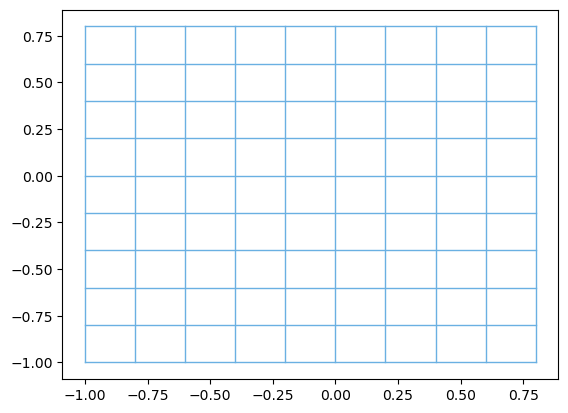

In [ ]:
#Function for plotting meshes
def meshplot(ax,x,y,clr,lw = 1.0):
    for k in range(y.shape[0]):
        ax.plot(x[k,:],y[k,:],color=clr,linewidth = lw)
    for k in range(x.shape[1]):
        ax.plot(x[:,k],y[:,k],color=clr,linewidth = lw)

[xm,ym] = np.meshgrid(np.arange(-1,1,0.2),np.arange(-1,1,0.2))

f,ax = plt.subplots()
meshplot(ax,xm,ym,zeiss_colors['ZEISSSkyBlue'])

In [ ]:
#Loading of image and computing of FOV

img = mpimg.imread('./testImage.png') #Reading of the image 
img.shape
img_fov_hor = 100 # Horizontal field of view of the image
img_fov_ver = img_fov_hor * img.shape[0] / img.shape[1] # Vertical field of view of the image
print(img_fov_ver) # Print vertical field of view

66.66666666666667


./mesh_input/SM-5A3/mesh.mat
(xd,yd) interpolation for meshplot
./mesh_input/SM0A3/mesh.mat
(xd,yd) interpolation for meshplot
./mesh_input/SM5A3/mesh.mat
(xd,yd) interpolation for meshplot


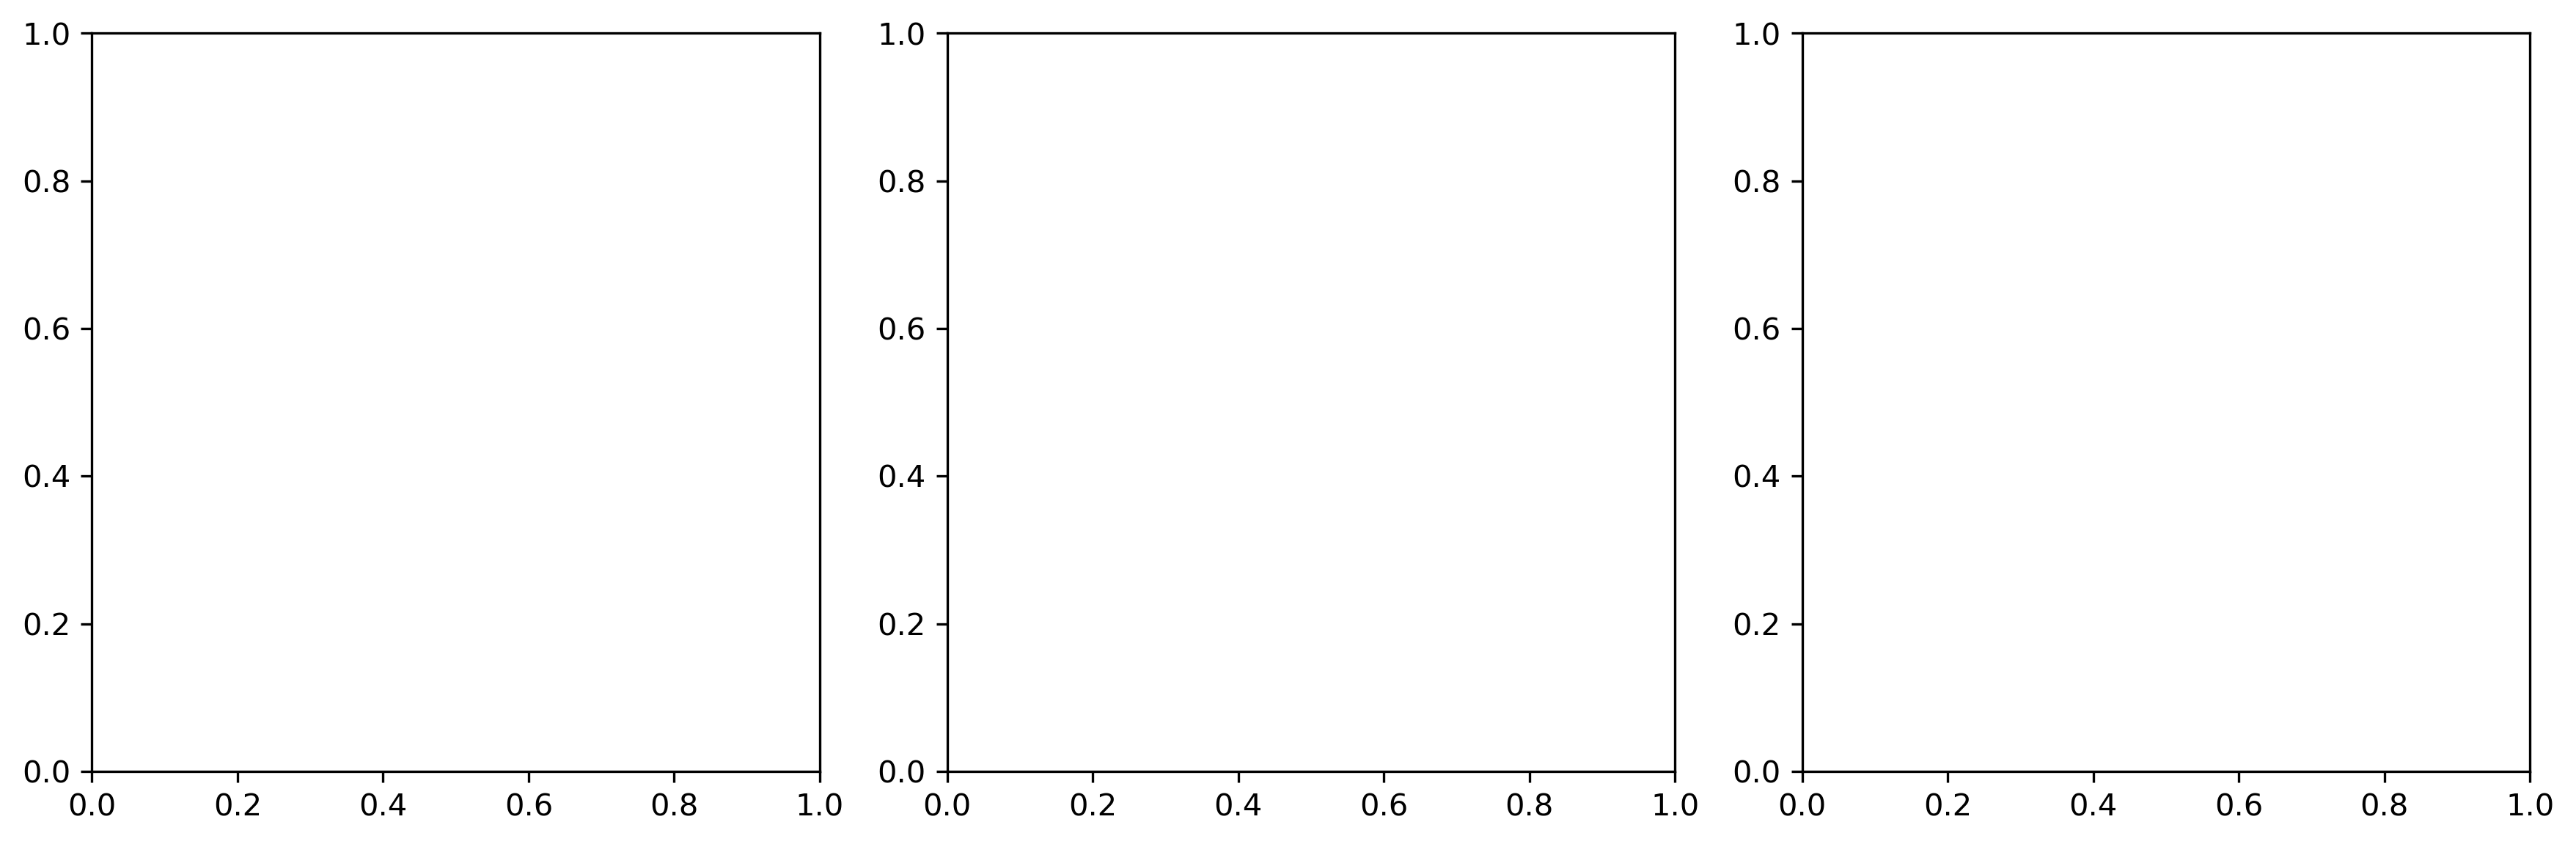

In [ ]:
#Building of sampling grid, loading of distortion meshes and plotting

from PIL import Image #Import from Python Imaging Library for image processing

# Setup of the lenses and their corresponding refraction values
lens_list = ['SM-5A3','SM0A3','SM5A3']
sph = [ -5, 0, 5]
add = [  3, 3, 3]

#Define a coarse mesh in image-plane coordinates to visualize forward mapping
xrange = np.linspace(-np.tan(np.radians(img_fov_hor/2)),np.tan(np.radians(img_fov_hor/2)),9)
yrange = np.linspace(-np.tan(np.radians(img_fov_ver/2)),np.tan(np.radians(img_fov_ver/2)),6)
[x,y] = np.meshgrid(xrange,yrange)

#Define extents of FOV and convert the extents to image-plane space
fov = [img_fov_hor/2, img_fov_hor/2, img_fov_ver/2, img_fov_ver/2] #Left-right-bottom-top extents in degrees
fov_imgplane = np.tan(np.radians(fov)) #Convert extents from degrees to radians

#Computation of half-sizes (semi-axes lengths) of the FOV box -> vector of semi-axes (a, b)
fov_center = np.array([fov_imgplane[1] - fov_imgplane[0] , fov_imgplane[3] - fov_imgplane[2]])/2

#Computation of center of the FOV box -> center point (x0, y0)
fov_axes = np.array([fov_imgplane[0] + fov_imgplane[1] , fov_imgplane[2] + fov_imgplane[3]])/2

#Getting points of ellipse for plotting FOV
theta = np.linspace(0,2*np.pi,2000)
x_ellipse = fov_axes[0] * np.cos(theta) + fov_center[0]
y_ellipse = fov_axes[1] * np.sin(theta) + fov_center[1]

img_distorted = [] #Creation of array where the distorted image will be stored

#We have a list of lens, x, y, xrange, yrange, img and distort_image function available
for index,lens in enumerate(lens_list): #Loop over the lenses to load the corresponding mesh and distort the image
    file_path = './mesh_input/' + lens + '/mesh.mat'
    print(file_path)
    mat = mat73.loadmat(file_path)
    mesh_df = pd.DataFrame() #Creation of dataframe to hold mesh points
    #Take the undistorted mesh points, split x/y components and flatten to 1-D, storing it as columns in the dataframe
    mesh_df['orig_x'] = mat['mesh_orig'][:,:,0].flatten() 
    mesh_df['orig_y'] = mat['mesh_orig'][:,:,1].flatten()

    #Do the same with distorted mesh points
    mesh_df['dist_x'] = mat['mesh_dist'][:,:,0].flatten()
    mesh_df['dist_y'] = mat['mesh_dist'][:,:,1].flatten()

    #Clean up input by removing rows with at least one missing value (NaN)
    mesh_df = mesh_df.dropna()

    #Interpolation of forward transformation: find distorted point(xd,yd) for undistorted sampling point (xs,ys)
    print('(xd,yd) interpolation for meshplot')
    xd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_x'],(x,y),method='cubic') # Other options of interpolation: "nearest", "linear", "cubic"
    yd = sp.interpolate.griddata(mesh_df[['orig_x','orig_y']],mesh_df['dist_y'],(x,y),method='cubic') 

    #Compute the reverse mapping to warp the image
    img_distorted.append(distort_image(img,mesh_df,[xrange[0],xrange[-1]] ,[yrange[0],yrange[-1]]))

    #Convert float image to 8-bit per channel and save it and multiply by 255 to scale from [0,1] to [0,255]
    rgb_image = Image.fromarray((img_distorted[index]*255).astype(np.uint8))

    #Save the PNG for this lens
    rgb_image.save('distorted_image' + lens + '.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


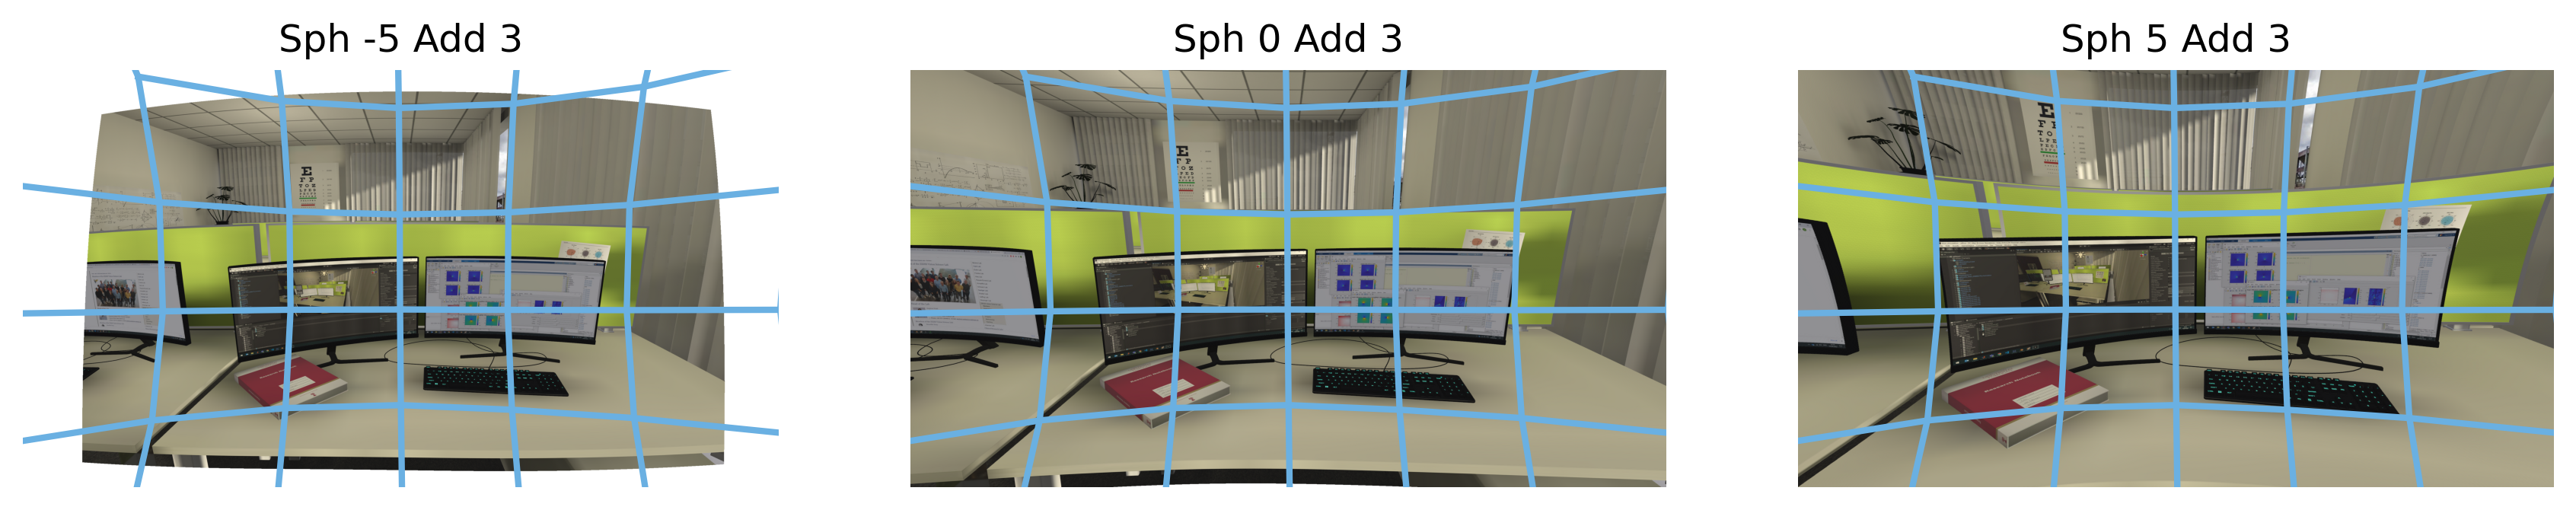

In [ ]:
cm = 1/2.54 #Specify size in cm
fig, ax = plt.subplots(1,3,figsize=(30*cm, 10*cm),dpi = 300) #Create a figure with 1 row and 3 columns with a figure size of 30x10 cm and a dpi=300 (high-resolution)
plt.tight_layout() #Auto-adjust subplots to fit in figure area.
for index,lens in enumerate(lens_list): #Loop over the three lenses to plot the distorted images and meshes
    #Show the precomputed distorted image for this lens
    ax[index].imshow(np.flipud(img_distorted[index]),origin='lower',extent=(xrange[0],xrange[-1],yrange[0],yrange[-1]))
    #meshplot(ax[index],x,y,zeiss_colors['ZEISSGray3Medium'],lw = 0.5)
    meshplot(ax[index],xd,yd,zeiss_colors['ZEISSSkyBlue'],lw = 2)
    #Draw a distorted mesh in blue over the image

    ax[index].set_title('Sph ' + str(sph[index]) + ' Add ' + str(add[index]))
    ax[index].set_xlim([xrange[0],xrange[-1]])
    ax[index].set_ylim([yrange[0],yrange[-1]])
    ax[index].axis('off')
    ax[index].set_aspect('equal')

plt.savefig('distortion_overview.svg', bbox_inches='tight', pad_inches = 0)

In [29]:
img_distorted*255

array([[[151.70192 , 145.40956 , 123.50768 ],
        [151.17365 , 144.95671 , 123.02843 ],
        [150.56941 , 144.56909 , 122.93814 ],
        ...,
        [127.0114  , 123.00253 , 105.99679 ],
        [127.0129  , 123.0046  , 105.996735],
        [126.97896 , 122.991066, 106.004745]],

       [[151.71327 , 145.59914 , 123.62859 ],
        [151.27577 , 145.07133 , 123.16087 ],
        [150.75978 , 144.77246 , 122.88611 ],
        ...,
        [127.01834 , 123.00317 , 105.99592 ],
        [127.00698 , 123.00313 , 105.99819 ],
        [126.98727 , 122.982315, 106.00614 ]],

       [[151.81972 , 145.86238 , 123.77    ],
        [151.39041 , 145.55289 , 123.32432 ],
        [150.8575  , 145.17374 , 122.95819 ],
        ...,
        [126.991936, 123.00757 , 105.99675 ],
        [126.999916, 123.00037 , 105.999916],
        [127.07359 , 122.96517 , 106.00728 ]],

       ...,

       [[163.64844 , 157.32541 , 129.11029 ],
        [166.93698 , 159.56294 , 132.73402 ],
        [172.06271 , 1